In [93]:
Packages <- c("dplyr", "geosphere", "fields","lattice", "ggplot2", "bbmle", "ncdf4","dplyr","tidyr", "stringr", "tidyverse", "raster", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/oceanography')
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")


In [2]:
#read in data and add site names
conn_mat_all <- brick("~/oceanography/ROMS/data/Camotes_Sea_Connectivity_Matrices_08_day_PLD_integer.nc", values=T) 
#read in the data for the number of grid cells per site (site ids are North- South, as in, Palanas is number 1)
sites_n <- read.table("~/oceanography/ROMS/input//camotes_vertices_sites_results_water_only.txt", sep=" ", header=T, stringsAsFactors = F)
#the order of sites in the connectivity matrix
sites_order <- read.table("~/oceanography/ROMS/input/sites_order_as_in_roms.txt", sep=" ", header=T, stringsAsFactors = F)

sites <- as.character(c("Palanas", "Wangag", "Magbangon", "Cabatoan", "Caridad Cemetery", "Caridad Proper", "Hicgop", "Hicgop South", "Sitio Tugas", "Elementary School", "Sitio Lonas", "San Agustin", "Poroc San Flower", "Poroc Rose", "Pangasugan", "Visca", "Gabas", "Tamakin Dacot", "Haina", "Sitio Baybayon", "SF1", "SF2", "SF3", "SF4", "SF5", "SF6", "CAI", "Other"))
site_ind <- c(seq(1,28, 1))
site_id <- as.data.frame(cbind(sites, site_ind), stringsAsFactors = F)
site_id$site_ind <- as.numeric(site_id$site_ind)


[1] "vobjtovarid4: **** WARNING **** I was asked to get a varid for dimension named sink BUT this dimension HAS NO DIMVAR! Code will probably fail at this point"
[1] "vobjtovarid4: **** WARNING **** I was asked to get a varid for dimension named source BUT this dimension HAS NO DIMVAR! Code will probably fail at this point"
[1] "vobjtovarid4: **** WARNING **** I was asked to get a varid for dimension named time BUT this dimension HAS NO DIMVAR! Code will probably fail at this point"


In [3]:
#add in dates (seasons here are field seasons, not monsoon seasons)
col <- "date"
col2 <- "index"

season1 <- as.data.frame(seq(as.Date("2010/10/01"), as.Date("2011/05/31"), by="days"))
names(season1) <- col

season2 <- as.data.frame(seq(as.Date("2011/10/01"), as.Date("2012/05/31"), by="days"))
names(season2) <- col

season3 <- as.data.frame(seq(as.Date("2012/10/01"), as.Date("2013/05/31"), by="days"))
names(season3) <- col

season4 <- as.data.frame(seq(as.Date("2013/10/01"), as.Date("2014/04/18"), by="days"))
names(season4) <- col

all_dates <- bind_rows(season1, season2, season3, season4)
time_step <- as.data.frame(seq(1,930,1))
names(time_step)<- col2
all_dates2 <- bind_cols(time_step, all_dates)
dim(all_dates2)


[1] 930   2

In [4]:
#make each daily connectivity matrix into a df and then pull them all together into a list
#conn_mat_list <- vector("list", nrow(all_dates2))

#date_df <- do.call("rbind", replicate(784, date, simplify = FALSE))

conn_mat_full <- as.data.frame(matrix(nrow=0, ncol=4))

cols_conn_mat <- c("date","sink", "source", "number")
cols_tmp <- c("sink", "source", "number")

names(conn_mat_full) <- cols_conn_mat

for(i in 1:nrow(all_dates2)){
    
    index_eval <- all_dates2$index[i]
    
    tmp <- as.data.frame(conn_mat_all[[i]], xy=T)   #pull out a data frame for each date
    names(tmp) <- cols_tmp
    
    date <- filter(all_dates2, index==index_eval)[2] #grab the date
    date_df <- do.call("rbind", replicate(784, date, simplify = FALSE)) #make a df of the date
    tmp2 <- bind_cols(date_df, tmp)

 
    conn_mat_full <- rbind(conn_mat_full, tmp2) 
}



In [5]:
#connect site names
conn_mat_full2 <- left_join(conn_mat_full, site_id, by=c(source="site_ind")) %>%
    dplyr::select(-source) %>%
    rename(source="sites")
    
conn_mat_full3 <- left_join(conn_mat_full2, site_id, by=c(sink="site_ind")) %>%
    dplyr::select(-sink) %>%
    rename(destination="sites")

    

In [83]:
#make all versions of Hicgop "Hicgop South" to match empirical data
conn_mat_full3 <- conn_mat_full3 %>%
    mutate(source=ifelse(source=="Hicgop", "Hicgop South", source)) %>%
    mutate(destination=ifelse(destination=="Hicgop", "Hicgop South", destination))
    

#trim out sand flats and other sites not represented in our sampling
conn_mat_full4 <- conn_mat_full3 %>%
    filter(source != "SF1" & source != "SF2" & source != "SF3"
           & source != "SF4" & source != "SF5" & source != "SF6" & source != "Pangasugan"  & source != "Other"& source != "CAI") %>%
    filter(destination != "SF1" & destination!= "SF2" & destination != "SF3"
           & destination != "SF4" & destination!= "SF5" & destination != "SF6"  & 
           destination!= "Pangasugan" & destination != "Other" & destination != "CAI") %>%
    mutate(month=month(ymd(date)))

#note to self, I think I messed up sources/destinations in the orginal for loop!!!! so I'm grouping by source below, but that's because the true destination column is misnamed "source" in the code and I haven't figured it out yet
#!!!!

#for unassigned, you want to keep these sites
ConnMatTotalRec <- conn_mat_full3 %>%     
    filter(date %in% season3$date) %>%
    group_by(destination) %>%
    #dplyr::select(-date) %>%
    mutate(SumParticlesRec= sum(number)) %>%
    distinct(destination, .keep_all = T) %>%
    dplyr::select(destination, SumParticlesRec)

nrow(ConnMatTotalRec) #should be 28-1, the total number of sites simulated after accounting for the Hicgop Merge


[1] 27

In [7]:
#put in North-South order for kernel fitting
SitesNS <- read.csv("~/parentage/text_file/sites_NS.txt", stringsAsFactors = F) %>%
    mutate(site=ifelse(site =="S. Magbangon" , "Magbangon", site)) %>%
    filter(site != "N. Magbangon") %>%
    dplyr::select( -index)

#SitesNS$index <- seq(1,18, 1) #might not need this....
#SitesNS$destination <- SitesNS$source


In [ ]:
which(SitesNS$site %!in% SimDisp2013$source)
SitesNS[9,]

In [175]:
#add together all of the particles for each season. At some point need to consider matching times that we sampled, from the fish meta-data
#replace XN with years
SimDispXNInt <- conn_mat_full4 %>%
    filter(date %in% season3$date | date %in% season2$date) %>%
    dplyr::select(-date, -month) %>%
    group_by(source, destination) %>%
    mutate(SumParticles= sum(number)) %>%
    distinct(source, destination, .keep_all = T) %>%
    dplyr::select(-number)

SimDispXNInt2 <- left_join(SitesNS, SimDispXNInt, by=c(site="source")) %>%
    rename(source="site")
SimDispXN <- left_join(SitesNS, SimDispXNInt2, by=c(site="destination")) %>%
    rename(destination="site") #%>% #drop this for fitting the kernel, use for the model
    #mutate(year="XN")

SimDispXNRecSampInt <- ConnMatTotalRec %>%#the total recruits in the simulation for each destination site we empirically sampled
    filter(destination %in% SimDispXN$destination) #%>%
    #mutate(source="unsampled") #not really, just unsampled empirically. Use this to get the unassigned row?

SimDispXNRecSamp <- left_join(SimDispXN, SimDispXNRecSampInt, by="destination") %>%
    group_by(destination) %>%
    mutate(TotalParticlesAssigned=sum(SumParticles)) %>%
    distinct(destination, .keep_all = T) %>%
    mutate(TotalUnassigned=SumParticlesRec-TotalParticlesAssigned) %>%
    dplyr::select(-source, -SumParticles) 


In [11]:
#check that everything looks correct

18*18 #this should be the rows
nrow(SimDisp2012)
nrow(SimDisp2012RecSamp)#should be 18 after the Hicgop merge

[1] 324

[1] 324

[1] 18

In [85]:
#sources are rows, columns are destinations, checked this? check again
#also check if it matters that these are in alphabetical order YES it should be alphabetical
SimDisp2013Mat <- SimDisp2013 %>%
    group_by(destination, source) %>%
    spread(destination, SumParticles)
#
rownames(SimDisp2013Mat) <- SimDisp2013Mat$source
SimDisp2013Mat$source <- NULL

Warning message:
“Setting row names on a tibble is deprecated.”

In [86]:
#add in unassigned 
RowtoAddInt <- SimDisp2013RecSamp %>%
    ungroup() %>%
    arrange(destination) %>%
    dplyr::select(TotalUnassigned)

RowtoAdd <- as.data.frame(t(RowtoAddInt))
colnames(RowtoAdd) <- colnames(SimDisp2013Mat)

FullSimDisp2013 <- rbind(SimDisp2013Mat, RowtoAdd)
rownames(FullSimDisp2013) <- NULL

In [71]:
FullSimDisp2012

NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
454,699,877,8,0,0,651,429,66,13,22,87,416,87,59,0,0,126
310,1761,1132,44,0,0,84,354,57,10,32,199,357,166,54,0,0,69
404,563,784,11,0,0,77,291,35,19,92,325,442,307,71,0,0,53
185,360,769,524,0,5,1536,246,31,42,70,176,193,252,652,0,0,31
48,35,95,961,6253,38,654,73,8,172,448,2136,102,3555,912,25,2843,5
16,1,9,127,20,1366,40,9,1,27,36,78,10,19,49,827,41,0
554,862,1587,531,4,19,1208,337,90,174,353,484,615,677,513,12,4,140
400,1034,1146,12,0,0,343,175,177,6,15,71,688,71,45,0,0,215
209,161,190,1,0,0,12,143,42,0,0,0,1406,0,13,0,0,239
63,180,418,419,1,36,179,7,6,273,506,811,75,2011,440,32,99,13


In [35]:
SimDisp2012Mat

Cabatoan,Caridad Cemetery,Caridad Proper,Elementary School,Gabas,Haina,Hicgop South,Magbangon,Palanas,Poroc Rose,Poroc San Flower,San Agustin,Sitio Baybayon,Sitio Lonas,Sitio Tugas,Tamakin Dacot,Visca,Wangag
454,699,877,8,0,0,651,429,66,13,22,87,416,87,59,0,0,126
310,1761,1132,44,0,0,84,354,57,10,32,199,357,166,54,0,0,69
404,563,784,11,0,0,77,291,35,19,92,325,442,307,71,0,0,53
185,360,769,524,0,5,1536,246,31,42,70,176,193,252,652,0,0,31
48,35,95,961,6253,38,654,73,8,172,448,2136,102,3555,912,25,2843,5
16,1,9,127,20,1366,40,9,1,27,36,78,10,19,49,827,41,0
554,862,1587,531,4,19,1208,337,90,174,353,484,615,677,513,12,4,140
400,1034,1146,12,0,0,343,175,177,6,15,71,688,71,45,0,0,215
209,161,190,1,0,0,12,143,42,0,0,0,1406,0,13,0,0,239
63,180,418,419,1,36,179,7,6,273,506,811,75,2011,440,32,99,13


In [87]:
#turn into parentage matrix

#SimDisp2012Mat <- SimDisp2012 %>%
#    ungroup() %>%
#    spread(source, destination, SumParticles)
    

#make the rest of the kernel input files
Assignments <- FullSimDisp2013
Adult_sample_proportions <- matrix(nrow=18, ncol=1, 1) #we sampled all sites completely because we are working with simulated data
Sampled_reefs <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/site_index_all.csv", header=FALSE))[,18] #sampled all reefs in the distance matrix/area/centroid files
Distances <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/distance_matrix_unsurveyed.csv", header=FALSE))[-2, -2]  #drop a magbangon row  
Reef_sizes <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/area_unsurveyed.csv", header=FALSE))[]
Centroids <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/centroids_unsurveyed.csv", header=T))



In [88]:
a=-10
b=10


x <- list(Distances=Distances, Assignments=Assignments, Sampled_reefs=Sampled_reefs, Reef_sizes=Reef_sizes, Adult_sample_proportions=Adult_sample_proportions) #put inputs into a list because that's the bbmle format

Sim2013Fit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 8), method="L-BFGS-B", data=x, control=list(maxit=500)))
Sim2013Fit

#doen't look right. Maybe fix theta, optimize k


Call:
mle2(minuslogl = LL_kt_bbmle, start = list(k = -3, theta = 1), 
    method = "L-BFGS-B", data = x, lower = c(-10, 0.15), upper = c(10, 
        8), control = list(maxit = 500))

Coefficients:
    k theta 
   10     8 

Log-likelihood: -47193.78 

In [110]:
#try predicting the occurence of dispersal numbers with some kind of regression model
#join together all of the data first

#get a data frame with number of genetic observations and number of simulated for each site to site pair, as well as a pairwise distance matrix
centroids <- read.csv("~/parentage/kernel_fitting/1340_loci/input/site_centroids.csv", header=TRUE, stringsAsFactors = F) %>%
    mutate(site=ifelse(site =="S.Magbangon" , "Magbangon", site)) %>%
    filter(site != "N.Magbangon") %>%
    filter(site %in% SitesNS$site)


##calculate the distance from all potential parents and all potential offspring
all_possible_dists <- as.data.frame(rdist.earth(as.matrix(centroids[,c('lon', 'lat')]), as.matrix(centroids[,c('lon', 'lat')]), miles=FALSE, R=6371))
#
##attach the sample_ids to each distance, so you can also get site and year
colnames(all_possible_dists) <- centroids$site
all_possible_dists$site_i <- centroids$site
#
##gather into tidy 
all_possible_dists_tidy <- all_possible_dists %>%
    dplyr::select(site_i, everything()) %>%
    gather(2:19, key=site_j, value=dist_km) 
nrow(all_possible_dists_tidy)




[1] 324

In [120]:
head(all_possible_dists_tidy)
head(SimDisp2012)

site_i,site_j,dist_km
Cabatoan,Cabatoan,0.000000
Caridad Cemetery,Cabatoan,3.038692
Caridad Proper,Cabatoan,3.789504
Elementary School,Cabatoan,7.740421
Gabas,Cabatoan,15.924821
Haina,Cabatoan,24.577900


destination,source,SumParticles
Palanas,Palanas,42
Palanas,Wangag,221
Palanas,Magbangon,177
Palanas,Cabatoan,66
Palanas,Caridad Cemetery,57
Palanas,Caridad Proper,35


In [178]:
disp_dist <- read.csv(file="~/parentage/colony2/20200605_1340loci/results//20200624colony_dispersaldirection.csv", header=T, stringsAsFactors=F) %>%
    #filter(year=="2014") %>%#testing effect of time
    filter(year %in% c("2012", "2013")) %>% #, "2014"
    dplyr::select(year, dist_par_km, offs_site, par_site) %>%
    group_by(offs_site, par_site) %>%
    summarise(obs_disp=n())

sum(disp_dist$obs_disp)#should be 37 for years of overlap between model and genetics, 21 for 2013

`summarise()` regrouping output by 'offs_site' (override with `.groups` argument)


[1] 24

In [171]:
disp_dist

offs_site,par_site,obs_disp
Cabatoan,S. Magbangon,1
Elementary School,Palanas,2
Haina,S. Magbangon,1
N. Magbangon,N. Magbangon,2
N. Magbangon,Palanas,1
Palanas,Palanas,3
Palanas,Sitio Baybayon,3
Palanas,Visca,2
Palanas,Wangag,3
Poroc San Flower,S. Magbangon,1


In [ ]:
#the all year is SimDispXN

In [179]:
SimPlusGenWithDistInt <- left_join(SimDispXN, all_possible_dists_tidy, by=c(destination="site_j", source="site_i")) %>%
    rename(ExpDisp="SumParticles")

SimPlusGenWithDist <- left_join(SimPlusGenWithDistInt, disp_dist, by=c(destination="offs_site", source="par_site")) %>%
    mutate(obs_disp=ifelse(is.na(obs_disp), 0, obs_disp))


In [180]:
test_mod <- glm(obs_disp ~ ExpDisp + dist_km, data=SimPlusGenWithDist, family="poisson")
summary(test_mod)



Call:
glm(formula = obs_disp ~ ExpDisp + dist_km, family = "poisson", 
    data = SimPlusGenWithDist)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5035  -0.3880  -0.3447  -0.2931   3.9476  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.0074902  0.4398954  -4.564 5.03e-06 ***
ExpDisp     -0.0003584  0.0003448  -1.040   0.2985    
dist_km     -0.0665931  0.0390462  -1.705   0.0881 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 142.27  on 323  degrees of freedom
Residual deviance: 137.85  on 321  degrees of freedom
AIC: 169.28

Number of Fisher Scoring iterations: 7


In [150]:
test_mod <- glm(obs_disp ~ ExpDisp + dist_km, data=SimPlusGenWithDist, family="poisson")
summary(test_mod)

#following this tutorial
#https://stats.idre.ucla.edu/r/dae/poisson-regression/
#the median is not quite 0, but close. if the median deviance is 0, then the deviance residuals are approximately normal and the model is specified correctly



Call:
glm(formula = obs_disp ~ ExpDisp + dist_km, family = "poisson", 
    data = SimPlusGenWithDist)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6338  -0.5901  -0.5535  -0.5168   6.2259  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.678e+00  2.301e-01  -7.291 3.09e-13 ***
ExpDisp      1.267e-05  5.805e-06   2.183    0.029 *  
dist_km     -2.103e-02  2.035e-02  -1.033    0.301    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 298.09  on 323  degrees of freedom
Residual deviance: 293.28  on 321  degrees of freedom
AIC: 358.84

Number of Fisher Scoring iterations: 13


In [149]:
#this isn't significant, which means the residual difference is small enough here to say the model fits reasonably well
with(test_mod, cbind(res.deviance = deviance, df = df.residual,
  p = pchisq(deviance, df.residual, lower.tail=FALSE)))


res.deviance,df,p
294.389,322,0.8630909


In [ ]:
#how much devience is explained here?

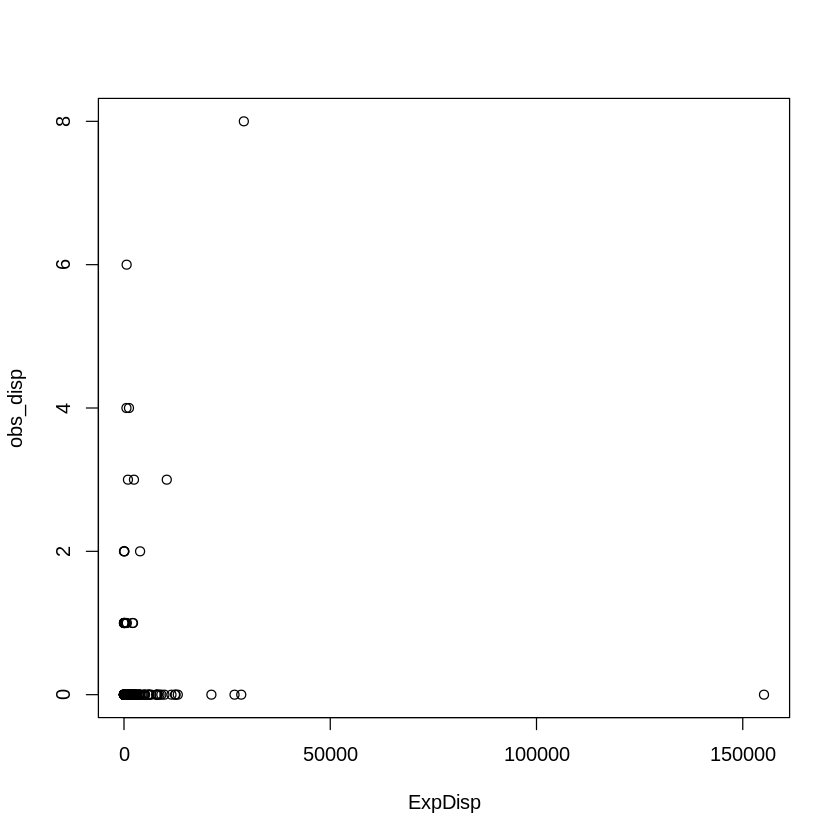

In [147]:
plot(obs_disp ~ ExpDisp, data=SimPlusGenWithDist)

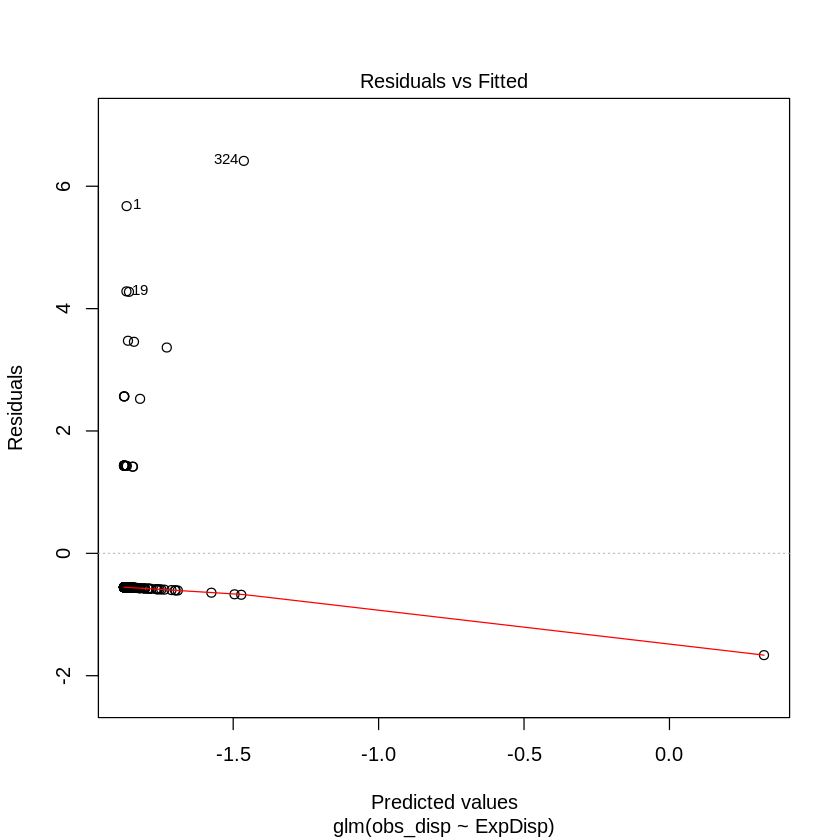

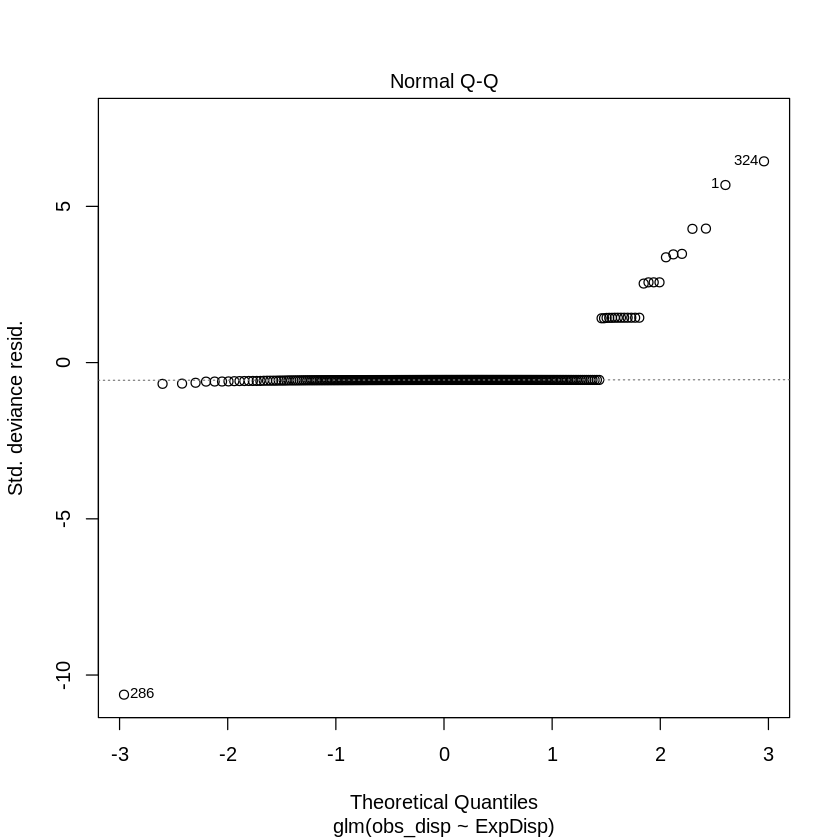

Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”

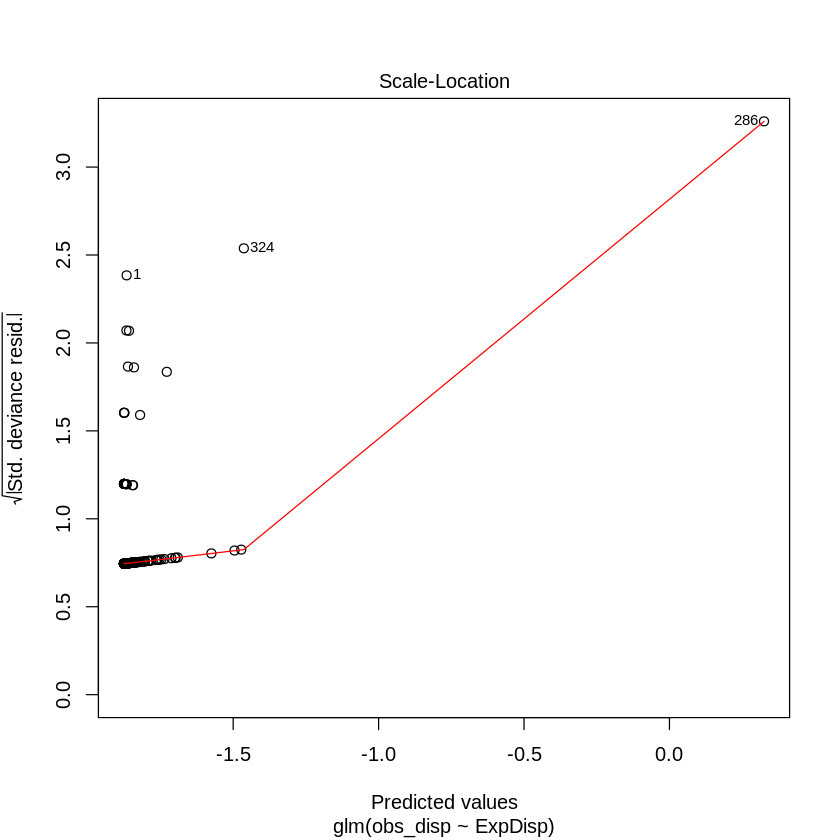

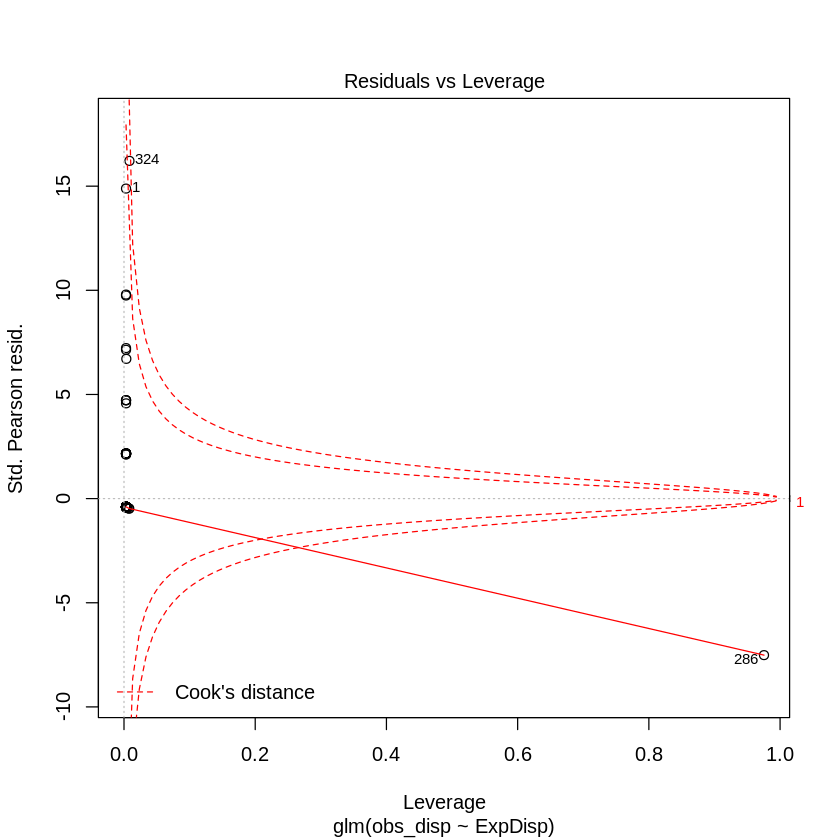

In [148]:
plot(test_mod)

In [ ]:
#monsoon season prep
NEM_months <- c(11, 12, 1, 2, 3, 4)
SWM_months <- c(5, 6, 7, 8, 9, 10)

NEM <- conn_mat_full4 %>%
    filter(month %in% NEM_months) %>%
    group_by(source, destination) %>%
    summarise(conn=max(fraction))

SWM <- conn_mat_full4 %>%
    filter(month %in% SWM_months) %>%
    group_by(source, destination) %>%
    summarise(conn=max(fraction))